In [1]:
!pip install torch-scatter torch-sparse torch-geometric rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 32.9 MB/s eta 0:00:0000:0100:01
  Created wheel for torch-scatter: filename=torch_scatter-2.1.1-cp37-cp37m-linux_x86_64.whl size=3561764 sha256=a116166f28f7a7e70d4db5573c8be2108568f0fb6c84e4875b16776811adefb6
  Stored in directory: /root/.cache/pip/wheels/d1/a7/30/10255fdd299a5650b73c802ec1e308221e4d859ed99243aa96
  Created wheel for torch-sparse: filename=torch_sparse-0.6.17-cp37-cp37m-linux_x86_64.whl size=2625649 sha256=e23620c30f6f1554a1d512d49d5909a2ac4048a4d53fc329743cf8

In [13]:
import networkx as nx
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
# from torch_geometric.nn import global_mean_pool as gmeanp, global_max_pool as gmaxp, global_add_pool
from torch_geometric.nn import global_add_pool, NNConv

# from torch_geometric.nn import (NNConv,global_mean_pool,graclus,max_pool,max_pool_x,)
# from torch_geometric.utils import to_networkx
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
def feed_forward(input_dim, hidden_dim, output_dim, num_hidden_layers, activation=nn.ReLU):
    dims = [input_dim] + [hidden_dim] * num_hidden_layers
    layers = []
    for i in range(num_hidden_layers):
        layers.append(nn.Linear(dims[i], dims[i + 1]))
        layers.append(activation())
    layers.append(nn.Linear(hidden_dim, output_dim))
    return nn.Sequential(*layers)

def convert_2_node(all_graph):
    shape_0 = all_graph.shape[0]
    meo = torch.reshape(all_graph,(shape_0,12,3))
    return meo
def get_feature_node(all_graph): #all_graph.shape = 32, 24, 3 - 32 đồ thị, 24 đỉnh, 3 đặc trưng mỗi đỉnh
    all_node_feature = []
    num_nodes = all_graph.shape[1]
    num_graph = all_graph.shape[0]
    for graph in range(num_graph):
        all_node_feature.append([])
        for node in range(num_nodes):
            x = all_graph[graph][node][0]
            y = all_graph[graph][node][1]
            z = all_graph[graph][node][2]
            mau_so = torch.sqrt( x**2 + y**2 + z**2 )
            x_axis = torch.acos(x / mau_so)
            y_axis = torch.acos(y / mau_so)
            z_axis = torch.acos(z / mau_so)
            all_node_feature[graph].append([x, y, z, x_axis, y_axis, z_axis])
    return torch.Tensor(all_node_feature)

def get_feature_edge(all_graph, edge): #all_graph.shape = 32, 24, 3 - 32 đồ thị, 24 đỉnh, 6 đặc trưng mỗi đỉnh
    all_edge_feature = [] # x, y, z, x_axis, y_axis, z_axis
    for graph in all_graph:
        edge_graph = edge.shape[1]
        edge_feature = []
        for edge_index in range(edge_graph):
            node_0 = edge[0][edge_index]
            node_1 = edge[1][edge_index]
            feature_node_0 = graph[node_0]
            feature_node_1 = graph[node_1]

            delta_x  = feature_node_1[0] - feature_node_0[0]
            delta_y  = feature_node_1[1] - feature_node_0[1]
            delta_z = feature_node_1[2] - feature_node_0[2]
            
            delta_phi_x_axis = feature_node_1[3] - feature_node_0[3]
            delta_phi_y_axis = feature_node_1[4] - feature_node_0[4]
            delta_phi_z_axis = feature_node_1[5] - feature_node_0[5]
            
            khoang_cach_2_dinh = torch.sqrt( delta_x**2 + delta_y**2 + delta_z**2)

            tu_so = feature_node_1[0]*feature_node_0[0] + feature_node_1[1]*feature_node_0[1] + feature_node_1[2]*feature_node_0[2]
            mau_so_1 = feature_node_1[0]**2 + feature_node_1[1]**2 + feature_node_1[2]**2
            mau_so_0 = feature_node_0[0]**2 + feature_node_0[1]**2 + feature_node_0[2]**2
            goc_giua_2_dinh = torch.acos( tu_so / torch.sqrt( mau_so_1 * mau_so_0 ))
            
            ff_edge = torch.Tensor([delta_x, delta_y, delta_z, delta_phi_x_axis, delta_phi_y_axis, delta_phi_z_axis, khoang_cach_2_dinh, goc_giua_2_dinh])
            edge_feature.append(ff_edge.tolist())
        all_edge_feature.append(edge_feature)
    return torch.Tensor(all_edge_feature)

In [21]:
violent_0_100 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_0_100.csv")
violent_100_200 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_100_200.csv")
violent_200_300 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_200_300.csv")
violent_300_400 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_300_400.csv")
violent_400_500 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_400_500.csv")
violent_500_600 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_500_600.csv")
violent_600_700 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_600_700.csv")
violent_700_800 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_700_800.csv")
violent_800_900 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_800_900.csv")
violent_900_1000 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/fight_900_1000.csv")

# violent_0_100 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/violent_hockey_0_200.csv")
# violent_100_200 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/violent_hockey_200_400.csv")
# violent_200_300 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/violent_hockey_400_500.csv")

normal_0_100 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_0_100.csv")
normal_100_200 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_100_200.csv")
normal_200_300 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_200_300.csv")
normal_300_400 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_300_400.csv")
normal_400_500 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_400_500.csv")
normal_500_600 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_500_600.csv")
normal_600_700 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_600_700.csv")
normal_700_800 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_700_800.csv")
normal_800_900 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_800_900.csv")
normal_900_1000 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-rwf2000/nonfight_900_1000.csv")


# normal_0_100 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/nonviolent_hockey_0_200.csv")
# normal_100_200 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/nonviolent_hockey_200_400.csv")
# normal_200_300 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/nonviolent_hockey_400_500.csv")

violent_0_100 = violent_0_100.append(violent_100_200)
violent_0_100 = violent_0_100.append(violent_200_300)
violent_0_100 = violent_0_100.append(violent_300_400)
violent_0_100 = violent_0_100.append(violent_400_500)
violent_0_100 = violent_0_100.append(violent_500_600)
violent_0_100 = violent_0_100.append(violent_600_700)
violent_0_100 = violent_0_100.append(violent_700_800)
violent_0_100 = violent_0_100.append(violent_800_900)
violent_0_100 = violent_0_100.append(violent_900_1000)

normal_0_100 = normal_0_100.append(normal_100_200)
normal_0_100 = normal_0_100.append(normal_200_300)
normal_0_100 = normal_0_100.append(normal_300_400)
normal_0_100 = normal_0_100.append(normal_400_500)
normal_0_100 = normal_0_100.append(normal_500_600)
normal_0_100 = normal_0_100.append(normal_600_700)
normal_0_100 = normal_0_100.append(normal_700_800)
normal_0_100 = normal_0_100.append(normal_800_900)
normal_0_100 = normal_0_100.append(normal_900_1000)

In [22]:
feature_violent = violent_0_100.iloc[:,1:].values
feature_violent = torch.from_numpy(feature_violent)
print(f"Hockey fight: {feature_violent.shape}")

feature_non_violent = normal_0_100.iloc[:,1:].values
feature_non_violent = torch.from_numpy(feature_non_violent)
print(f"hockey non fight: {feature_non_violent.shape}")

Hockey fight: torch.Size([14043, 36])
hockey non fight: torch.Size([13625, 36])


Features and labels

In [23]:
feature_violent_g = convert_2_node(feature_violent)
label_violent_g = torch.ones(feature_violent.shape[0])

feature_non_violent_g = convert_2_node(feature_non_violent)
label_non_violent_g = torch.zeros(feature_non_violent.shape[0])

In [26]:
feature = torch.concat((feature_violent_g, feature_non_violent_g), 0)
feature = feature.numpy()

label = torch.concat((label_violent_g, label_non_violent_g), 0)
label = to_categorical(label)


x_train_single_all, x_test_single, y_train_single_all, y_test_single = train_test_split(feature, label, test_size=0.2)
x_train_single, x_val_single, y_train_single, y_val_single = train_test_split(x_train_single_all, y_train_single_all, test_size=0.25)



x_train_single = torch.from_numpy(x_train_single)
x_test_single = torch.from_numpy(x_test_single)
x_val_single = torch.from_numpy(x_val_single)


y_train_single = torch.from_numpy(y_train_single)
y_test_single = torch.from_numpy(y_test_single)
y_val_single = torch.from_numpy(y_val_single)


print(f"x_train_single: {x_train_single.shape}")
print(f"y_train_single: {y_train_single.shape}")
print(f"x_test_single: {x_test_single.shape}")
print(f"y_test_single: {y_val_single.shape}")

train_data_single = torch.utils.data.TensorDataset(x_train_single, y_train_single)
train_iter = torch.utils.data.DataLoader(train_data_single, batch_size = 1024, shuffle=True)

test_data_single = torch.utils.data.TensorDataset(x_test_single, y_test_single)
test_iter = torch.utils.data.DataLoader(test_data_single, batch_size = 1024, shuffle=True)

val_data_single = torch.utils.data.TensorDataset(x_val_single, y_val_single)
val_iter = torch.utils.data.DataLoader(val_data_single, batch_size = 1024, shuffle=True)

x_train_single: torch.Size([16600, 12, 3])
y_train_single: torch.Size([16600, 2])
x_test_single: torch.Size([5534, 12, 3])
y_test_single: torch.Size([5534, 2])


In [7]:
# # # Sample 
# feature = torch.rand(100, 12, 3).float()
# label = torch.randint(0,2 ,(100, 1))
# label = to_categorical(label)
# label = torch.from_numpy(label)
# train_data = torch.utils.data.TensorDataset(feature, label)
# train_iter = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True)
# test_iter = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True)
# val_iter = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu") # cuda
edge_index = torch.Tensor([
    [ 4,  2,  2,  0,  0,  0,  1,  1,  1,  3,  3,  5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 10, 9],
    [ 2,  4,  0,  2,  1, 6,  0, 7,  3,  1,  5,  3,  0, 7, 8,  1, 6, 9, 6, 10, 7, 11, 8, 11]
]).long().to(device=device)

In [28]:
class Forward2(nn.Module):
    def __init__(self, node_input_dim, node_hidden_dim, node_output_dim, edge_input_dim, edge_hidden_dim):
        super(Forward2, self).__init__()
        
        init_sequential_1 = feed_forward(edge_input_dim, edge_hidden_dim, node_input_dim * node_hidden_dim, 1)
        self.conv_1 = NNConv(node_input_dim, node_hidden_dim, init_sequential_1, aggr='add')
        
        init_sequential_2 = feed_forward(edge_input_dim, edge_hidden_dim, node_hidden_dim * node_output_dim, 1)
        self.conv_2 = NNConv(node_hidden_dim, node_output_dim, init_sequential_2, aggr='add')
        
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(node_output_dim)
        self.linear = feed_forward(node_output_dim, 10, 2, 1)
        self.sm = nn.Softmax(dim=1)
    def forward(self, x, edge_index, return_current):
        edge_index = edge_index.to(device = x.device)
        x = get_feature_node(x).to(device = edge_index.device)
        edge_feature = get_feature_edge(x, edge_index).to(device = edge_index.device)
        time = x.shape[0]

        node_feature_1 = []
        for i in range(time):
            h = self.conv_1(x[i], edge_index, edge_feature[i])
            node_feature_1.append(h)
        node_feature_1 = torch.stack(node_feature_1).to(device = edge_index.device)
        node_feature_1 = F.relu(node_feature_1)
        node_feature_2 = []
        for i in range(time):
            h = self.conv_2(node_feature_1[i], edge_index, edge_feature[i])
            node_feature_2.append(h)
        node_feature_2 = torch.stack(node_feature_2).to(device = edge_index.device)
        node_feature_2 = F.relu(node_feature_2)

        if return_current:
            return node_feature_2, edge_feature
        num_nodes = node_feature_2.shape[1]
        zeros = torch.zeros(num_nodes).long().to(device = edge_index.device)
        h = global_add_pool(node_feature_2, zeros)
        h = self.flatten(h)
        h = self.batch_norm(h)
        h = self.linear(h)
        h = self.sm(h)
        return h
    
node_input_dim = 6
edge_input_dim = 8

node_hidden_dim = 5
node_output_dim = 3

edge_hidden_dim = 5
    
model = Forward2(node_input_dim, node_hidden_dim, node_output_dim, edge_input_dim, edge_hidden_dim)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.to(device)
total_para = sum(p.numel() for p in model.parameters())
print(total_para)
# for name, param in model.named_parameters():
#     print(f"{name}: {param}")
#     print("####")

481


In [29]:
epochs_time_nnconv = []

epochs_loss_nnconv = []
epochs_acc_nnconv_accuracy = []
epochs_acc_nnconv_precision = []
epochs_acc_nnconv_recall = []
epochs_acc_nnconv_f1 = []

epochs_test_loss_nnconv = []
epochs_test_acc_nnconv_accuracy = []
epochs_test_acc_nnconv_precision = []
epochs_test_acc_nnconv_recall = []
epochs_test_acc_nnconv_f1 = []

loss_list, test_loss_list = [], []

acc_f1, test_acc_f1 = [], []
acc_accuracy, test_acc_accuracy = [], []
acc_precision, test_acc_precision = [], []
acc_recall, test_acc_recall = [], []

for i in range(100):
 
    model.train()
    for x,y in train_iter:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad() 
        pred = model(x, edge_index, False)

        loss = loss_fn(pred, y)
        loss_list.append(loss.item())
        

        ground_truth = torch.argmax(y, dim=1).cpu().detach().numpy()
        pred_ind = torch.argmax(pred, dim=1).cpu().detach().numpy()
        
        accuracy = accuracy_score(ground_truth, pred_ind)
        acc_accuracy.append(accuracy)
        
        precision = precision_score(ground_truth, pred_ind, average= "micro")
        acc_precision.append(precision)
        
        recall = recall_score(ground_truth, pred_ind,  average='micro')
        acc_recall.append(recall)
        
        f1 = f1_score(ground_truth, pred_ind, average="micro")
        acc_f1.append(f1)
        
        loss.backward()
        optimizer.step()
        
    model.eval()
    for x_test,y_test in test_iter:

        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test, edge_index, False)
        loss_test = loss_fn(pred_test, y_test)
        test_loss_list.append(loss_test.item())

        
        ground_truth_test = torch.argmax(y_test, dim=1).cpu().detach().numpy()
        pred_ind_test = torch.argmax(pred_test, dim=1).cpu().detach().numpy()
        
        test_accuracy = accuracy_score(ground_truth_test, pred_ind_test)
        test_acc_accuracy.append(test_accuracy)
        
        test_precision = precision_score(ground_truth_test, pred_ind_test, average= "micro")
        test_acc_precision.append(test_precision)
        
        test_recall = recall_score(ground_truth_test, pred_ind_test,  average='micro')
        test_acc_recall.append(test_recall)
    
        test_f1 = f1_score(ground_truth_test, pred_ind_test, average="micro")
        test_acc_f1.append(test_f1)
        
    epochs_time_nnconv.append(i)
    
    total_loss = sum(loss_list)/len(loss_list)
    test_total_loss = sum(test_loss_list)/len(test_loss_list)
    epochs_loss_nnconv.append(total_loss)
    epochs_test_loss_nnconv.append(test_total_loss)
    
    total_accuracy = sum(acc_accuracy)/len(acc_accuracy)
    test_total_accuracy = sum(test_acc_accuracy)/len(test_acc_accuracy)
    epochs_acc_nnconv_accuracy.append(total_accuracy)
    epochs_test_acc_nnconv_accuracy.append(test_total_accuracy)
    
    total_precision = sum(acc_precision)/len(acc_precision)
    test_total_precision = sum(test_acc_precision)/len(test_acc_precision)
    epochs_acc_nnconv_precision.append(total_precision)
    epochs_test_acc_nnconv_precision.append(test_total_precision)
    
    total_recall = sum(acc_recall)/len(acc_recall)
    test_total_recall = sum(test_acc_recall)/len(test_acc_recall)
    epochs_acc_nnconv_recall.append(total_recall)
    epochs_test_acc_nnconv_recall.append(test_total_recall)
    
    total_f1 = sum(acc_f1)/len(acc_f1)
    test_total_f1 = sum(test_acc_f1) / len(test_acc_f1)
    epochs_acc_nnconv_f1.append(total_f1)
    epochs_test_acc_nnconv_f1.append(test_total_f1)
    
    print(f"Epochs: {i}, loss: {total_loss}, test loss: {test_total_loss}")
    print(f"Accuracy acc: {total_accuracy}, test accuracy acc: {test_total_accuracy}")
    print(f"Accuracy precision: {total_precision}, test accuracy precision: {test_total_precision}")
    print(f"Accuracy recall: {total_recall}, test accuracy recall: {test_total_recall}")
    print(f"Accuracy f1: {total_f1}, test accuracy f1: {test_total_f1}")
    print(f"=======================================================================")

Epochs: 0, loss: 0.6857311410062453, test loss: 0.6843105455239614
Accuracy acc: 0.5500685083061002, test accuracy acc: 0.5567947363123994
Accuracy precision: 0.5500685083061002, test accuracy precision: 0.5567947363123994
Accuracy recall: 0.5500685083061002, test accuracy recall: 0.5567947363123994
Accuracy f1: 0.5500685083061002, test accuracy f1: 0.5567947363123994
Epochs: 1, loss: 0.6816105947775, test loss: 0.6852763444185257
Accuracy acc: 0.5599564695669934, test accuracy acc: 0.5581007510567633
Accuracy precision: 0.5599564695669934, test accuracy precision: 0.5581007510567633
Accuracy recall: 0.5599564695669934, test accuracy recall: 0.5581007510567633
Accuracy f1: 0.5599564695669934, test accuracy f1: 0.5581007510567633
Epochs: 2, loss: 0.6787052025981978, test loss: 0.6812833382023705
Accuracy acc: 0.5687132636619462, test accuracy acc: 0.5654262802771068
Accuracy precision: 0.5687132636619462, test accuracy precision: 0.5654262802771068
Accuracy recall: 0.5687132636619462, t

KeyboardInterrupt: 

Loss val: 0.5784490207831064
Accuracy acc val: 0.7254384793447294
Accuracy precision val: 0.7254384793447294
Accuracy recall val: 0.7254384793447294
Accuracy f1 val: 0.7254384793447293


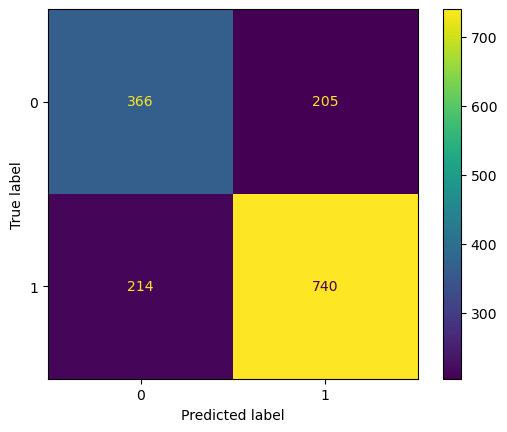

In [17]:
model.eval()
val_loss_list = []
val_acc_accuracy = []
val_acc_precision = []
val_acc_recall = []
val_acc_f1 = []

# Thêm confusion
pred_list = []
ground_truth_list = []
model.eval()
for x_val,y_val in val_iter:
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        pred_val = model(x_val, edge_index, False)
        loss_test = loss_fn(pred_val, y_val)
        val_loss_list.append(loss_test.item())

        ground_truth_val = torch.argmax(y_val, dim=1).cpu().detach().numpy()
        pred_ind_val = torch.argmax(pred_val, dim=1).cpu().detach().numpy()

        # Thêm confusion
        pred_list.append( torch.argmax(pred_val, dim=1))
        ground_truth_list.append(torch.argmax(y_val, dim=1))

        val_accuracy = accuracy_score(ground_truth_val, pred_ind_val)
        val_acc_accuracy.append(val_accuracy)
        
        val_precision = precision_score(ground_truth_val, pred_ind_val, average= "micro")
        val_acc_precision.append(val_precision)
        
        val_recall = recall_score(ground_truth_val, pred_ind_val,  average='micro')
        val_acc_recall.append(val_recall)
    
        val_f1 = f1_score(ground_truth_val, pred_ind_val, average="micro")
        val_acc_f1.append(val_f1)

val_total_loss = sum(val_loss_list)/len(val_loss_list)
val_total_accuracy = sum(val_acc_accuracy)/len(val_acc_accuracy)
val_total_precision = sum(val_acc_precision)/len(val_acc_precision)
val_total_recall = sum(val_acc_recall)/len(val_acc_recall)
val_total_f1 = sum(val_acc_f1) / len(val_acc_f1)

print(f"Loss val: {val_total_loss}")
print(f"Accuracy acc val: {val_total_accuracy}")
print(f"Accuracy precision val: {val_total_precision}")
print(f"Accuracy recall val: {val_total_recall}")
print(f"Accuracy f1 val: {val_total_f1}")
print(f"=======================================================================")

pred_list = torch.cat(pred_list)
ground_truth_list = torch.cat(ground_truth_list)
confusion_matrix = metrics.confusion_matrix(ground_truth_list.cpu().detach().numpy(), pred_list.cpu().detach().numpy())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

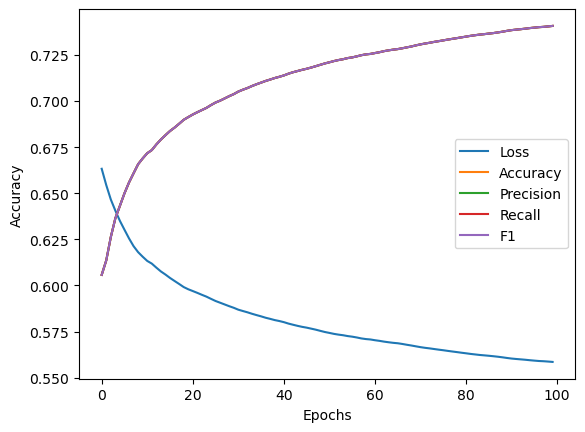

In [18]:
plt.plot(epochs_time_nnconv, epochs_loss_nnconv, label="Loss")
plt.plot(epochs_time_nnconv, epochs_acc_nnconv_accuracy, label="Accuracy")
plt.plot(epochs_time_nnconv, epochs_acc_nnconv_precision, label="Precision")
plt.plot(epochs_time_nnconv, epochs_acc_nnconv_recall, label="Recall")
plt.plot(epochs_time_nnconv, epochs_acc_nnconv_f1, label="F1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

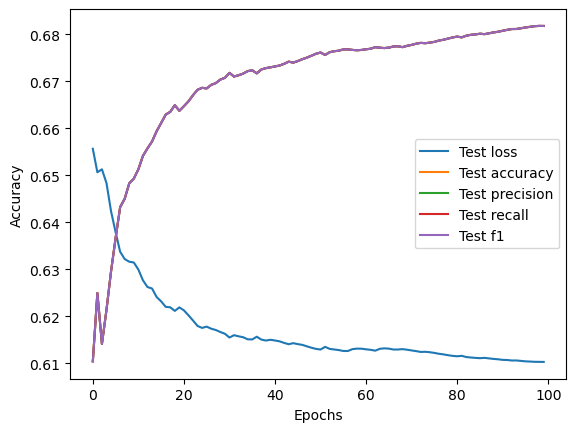

In [19]:
plt.plot(epochs_time_nnconv, epochs_test_loss_nnconv, label="Test loss")
plt.plot(epochs_time_nnconv, epochs_test_acc_nnconv_accuracy, label="Test accuracy")
plt.plot(epochs_time_nnconv, epochs_test_acc_nnconv_precision, label="Test precision")
plt.plot(epochs_time_nnconv, epochs_test_acc_nnconv_recall, label="Test recall")
plt.plot(epochs_time_nnconv, epochs_test_acc_nnconv_f1, label="Test f1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [20]:
data_n = {
    "loss": epochs_loss_nnconv,
    "accuracy_acc": epochs_acc_nnconv_accuracy,
    "accuracy_precision":epochs_acc_nnconv_precision,
    "accuracy_recall": epochs_acc_nnconv_recall,
    "accuracy_f1": epochs_acc_nnconv_f1,
    
    "test_loss": epochs_test_loss_nnconv,
    "test_accuracy_acc":epochs_test_acc_nnconv_accuracy,
    "test_accuracy_precision":epochs_test_acc_nnconv_precision,
    "test_accuracy_recall":epochs_test_acc_nnconv_recall,
    "test_accuracy_f1":epochs_test_acc_nnconv_f1
}
ga_n = pd.DataFrame(data_n)
ga_n.to_csv("nnconv_hockey.csv")
torch.save(model.state_dict(), 'model_nnconv_hockey.pth')